In [ ]:
from google.colab import drive
# Mount GDrive to connect Google Drive and Google Colab for reading/writing data.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
modeRun = 'colab' # Set the execution mode to 'colab' or 'local'
#modeRun = 'local'
if modeRun == 'colab': # Check if the execution mode is 'colab'
    from google.colab import drive # Import the drive module from google.colab
    drive.mount('/content/gdrive') # Mount Google Drive to access files
    train_dir = '/content/gdrive/MyDrive/Colab Notebooks/INTAR/project/chest_xray/train' # Define the directory path for training data in Google Drive
    val_dir = '/content/gdrive/MyDrive/Colab Notebooks/INTAR/project/chest_xray/val' # Define the directory path for validation data (although not directly used in image_dataset_from_directory with split)
    test_dir = '/content/gdrive/MyDrive/Colab Notebooks/INTAR/project/chest_xray/test' # Define the directory path for test data in Google Drive

else: # If the execution mode is not 'colab'
    dataPath = "./chest_xray/" # Define a local data path (this part is commented out by the default modeRun)

Mounted at /content/gdrive


Importing Libraries and Setting Parameters
tensorflow as tf:  To build and train our deep learning model.
from tensorflow.keras import layers, models: provides a high-level interface for building neural networks, making it easier to define model architectures.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

# Parameters
SEED = 42 # Set a seed for reproducibility
IMAGE_SIZE = (224, 224) # Define the target size for images
BATCH_SIZE = 32 # Set the batch size for training and evaluation
AUTOTUNE = tf.data.AUTOTUNE # Automatically tune the number of parallel calls for data loading

The code loads the image data, splits it into training, validation, and test sets, determines the class names, normalizes the pixel values, and optimizes the data loading pipeline for efficient training.

In [ ]:
# Data Loading
print('Training Images:') # Print a message indicating the start of training image loading
train_ds = image_dataset_from_directory(
    train_dir, # Directory containing the training images
    validation_split=0.1, # Reserve 10% of the images for validation
    subset='training', # Specify that this dataset is the training subset
    seed=SEED, # Seed for shuffling and transformations, for reproducibility
    image_size=IMAGE_SIZE, # Resize images to the specified size
    batch_size=BATCH_SIZE # Define the batch size for the dataset
)

print('Validation Images:') # Print a message indicating the start of validation image loading
val_ds = image_dataset_from_directory(
    train_dir, # Use the same directory as training for validation split
    validation_split=0.1, # Reserve 10% of the images for validation
    subset='validation', # Specify that this dataset is the validation subset
    seed=SEED, # Seed for shuffling and transformations, for reproducibility (should be the same as training for consistent split)
    image_size=IMAGE_SIZE, # Resize images to the specified size
    batch_size=BATCH_SIZE # Define the batch size for the dataset
)

print('Testing Images:') # Print a message indicating the start of testing image loading
test_ds = image_dataset_from_directory(
    test_dir, # Directory containing the test images
    seed=SEED, # Seed for shuffling and transformations, for reproducibility
    image_size=IMAGE_SIZE, # Resize images to the specified size
    batch_size=BATCH_SIZE # Define the batch size for the dataset
)

# Class names
class_names = train_ds.class_names # Get the class names from the training dataset
num_classes = len(class_names) # Get the number of classes

# Normalization
train_ds = train_ds.map(lambda x, y: (x / 255.0, y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE) # Normalize pixel values to [0, 1], cache, shuffle, and prefetch for performance
val_ds = val_ds.map(lambda x, y: (x / 255.0, y)).cache().prefetch(buffer_size=AUTOTUNE) # Normalize pixel values to [0, 1], cache, and prefetch for performance
test_ds = test_ds.map(lambda x, y: (x / 255.0, y)).cache().prefetch(buffer_size=AUTOTUNE) # Normalize pixel values to [0, 1], cache, and prefetch for performance

Training Images:
Found 5217 files belonging to 2 classes.
Using 4696 files for training.
Validation Images:
Found 5217 files belonging to 2 classes.
Using 521 files for validation.
Testing Images:
Found 624 files belonging to 2 classes.


This section of the code is dedicated to visualizing a few sample images from your training dataset. The code iterates through the first batch of training images and displays the first six images in a 2x3 grid, showing the image and its corresponding class name as the title for each subplot.

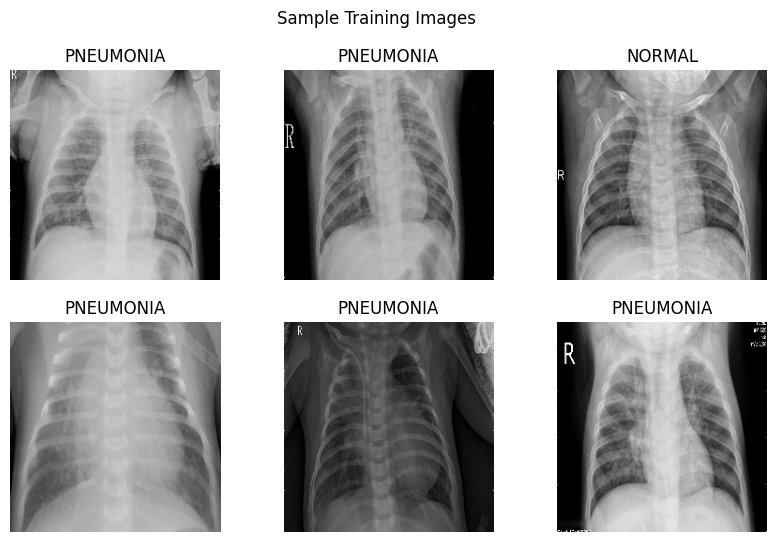

In [ ]:
# Data Visualization
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1): # Iterate through the first batch of the training dataset
    for i in range(6): # Loop through the first 6 images in the batch
        ax = plt.subplot(2, 3, i + 1) # Create a subplot for each image in a 2x3 grid
        plt.imshow(images[i]) # Display the image
        plt.title(class_names[labels[i]]) # Set the title of the subplot to the class name of the image
        plt.axis("off") # Turn off the axis
plt.suptitle("Sample Training Images") # Set a main title for the figure
plt.show() # Display the plot

Model Definition and Compilation
We utilize transfer learning by incorporating a pre-trained model and adding layers on top to adapt it to our specific task. Finally, we compile the model, setting up the optimizer, loss function, and metrics for training.

In [ ]:
# Model with Transfer Learning
base_model = ResNet50(include_top=False, input_shape=IMAGE_SIZE + (3,), weights='imagenet') # Load the ResNet50 model with pre-trained weights from ImageNet, excluding the top classification layer
base_model.trainable = False # Freeze the weights of the base model so they are not updated during training

model = models.Sequential([ # Create a sequential model
    base_model, # Add the pre-trained ResNet50 model as the first layer
    layers.GlobalAveragePooling2D(), # Add a Global Average Pooling layer to reduce spatial dimensions
    layers.Dropout(0.3), # Add a Dropout layer with a rate of 0.3 to prevent overfitting
    layers.Dense(128, activation='relu'), # Add a dense layer with 128 units and ReLU activation
    layers.Dense(num_classes, activation='softmax') # Add the output dense layer with the number of classes and softmax activation for multi-class classification
])

model.compile(optimizer='adam', # Configure the model for training
              loss='sparse_categorical_crossentropy', # Set the loss function to sparse categorical crossentropy (for integer labels)
              metrics=['accuracy']) # Set the metric to monitor during training to accuracy

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Early Stopping: is a technique used during model training to prevent overfitting. It monitors a performance metric on a validation dataset and stops training early if the metric stops improving for a set number of epochs. This helps to find the model that generalizes best to new data.

In [ ]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Define Early Stopping callback to prevent overfitting


In [ ]:
# Model Training
history = model.fit(train_ds, # Train the model on the training dataset
                    epochs=50, # Train for a maximum of 50 epochs
                    validation_data=val_ds, # Evaluate the model on the validation dataset after each epoch
                    callbacks=[early_stopping]) # Use the Early Stopping callback to stop training if validation loss stops improving


Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 88s 506ms/step - accuracy: 0.6870 - loss: 0.6527 - val_accuracy: 0.8503 - val_loss: 0.5024
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.7794 - loss: 0.4690 - val_accuracy: 0.8196 - val_loss: 0.3751
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.8061 - loss: 0.4302 - val_accuracy: 0.8560 - val_loss: 0.3969
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.8368 - loss: 0.3714 - val_accuracy: 0.8196 - val_loss: 0.3409
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 87ms/step - accuracy: 0.8198 - loss: 0.3857 - val_accuracy: 0.8157 - val_loss: 0.3622
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 86ms/step - accuracy: 0.8363 - loss: 0.3694 - val_accuracy: 0.8196 - val_loss: 0.3691
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.8203 - loss: 0.3968 - val_accuracy: 0.8618 - val_loss: 0.3192
Epoch 8/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.8364 - loss: 0.3566 -

Evaluate the model on the validation dataset:
The model.evaluate() method computes the loss and metrics for the given dataset.

In [ ]:
# Evaluate the model on the validation dataset
validation_loss, validation_accuracy = model.evaluate(val_ds) # Evaluate the model on the validation dataset to get loss and accuracy

# Print the validation loss and accuracy
print("Validation Loss:", validation_loss) # Print the calculated validation loss
print("Validation Accuracy:", validation_accuracy) # Print the calculated validation accuracy

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9273 - loss: 0.1861
Validation Loss: 0.18913103640079498
Validation Accuracy: 0.917466402053833


Model Evaluation on Test Data
This section of the code evaluates the trained deep learning model on the separate test dataset to assess its performance on unseen data.

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds) # Evaluate the model on the test dataset to get loss and accuracy

# Print the test loss and accuracy
print("Test Loss:", test_loss) # Print the calculated test loss
print("Test Accuracy:", test_accuracy) # Print the calculated test accuracy

20/20 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.7893 - loss: 0.4763
Test Loss: 0.4778362214565277
Test Accuracy: 0.7756410241127014


Training History Plot
After training the model, the model.fit() method returns a history object. This object contains valuable information about how the model performed on both the training and validation datasets during each epoch (a full pass through the training data).

By plotting the training and validation accuracy and loss over the epochs, we can gain insights into the model's learning process.

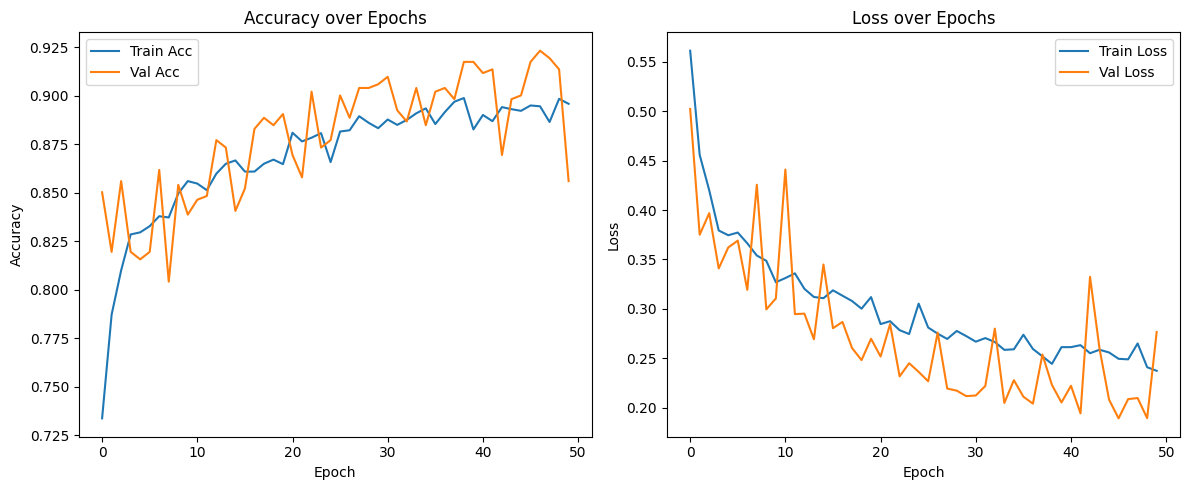

In [ ]:
# Training History Plot
def plot_history(hist): # Define a function to plot the training history
    plt.figure(figsize=(12, 5)) # Create a figure with a specified size

    # Accuracy
    plt.subplot(1, 2, 1) # Create the first subplot (1 row, 2 columns, 1st plot) for accuracy
    plt.plot(hist.history['accuracy'], label='Train Acc') # Plot the training accuracy over epochs
    plt.plot(hist.history['val_accuracy'], label='Val Acc') # Plot the validation accuracy over epochs
    plt.title('Accuracy over Epochs') # Set the title for the accuracy plot
    plt.xlabel('Epoch') # Set the x-axis label for the accuracy plot
    plt.ylabel('Accuracy') # Set the y-axis label for the accuracy plot
    plt.legend() # Display the legend for the accuracy plot

    # Loss
    plt.subplot(1, 2, 2) # Create the second subplot (1 row, 2 columns, 2nd plot) for loss
    plt.plot(hist.history['loss'], label='Train Loss') # Plot the training loss over epochs
    plt.plot(hist.history['val_loss'], label='Val Loss') # Plot the validation loss over epochs
    plt.title('Loss over Epochs') # Set the title for the loss plot
    plt.xlabel('Epoch') # Set the x-axis label for the loss plot
    plt.ylabel('Loss') # Set the y-axis label for the loss plot
    plt.legend() # Display the legend for the loss plot

    plt.tight_layout() # Adjust layout to prevent plots from overlapping
    plt.show() # Display the plot

plot_history(history) # Call the function to plot the training history using the 'history' object

After training the model, it's crucial to evaluate its performance on a separate dataset that it has not seen before. This is the purpose of the test dataset. This section of the code loads the test data, uses the trained model to make predictions, and then calculates and displays key performance metrics to understand how well the model generalizes and performs on unseen examples.


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 385ms/step

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.94      0.43      0.59       234
   PNEUMONIA       0.74      0.98      0.85       390

    accuracy                           0.78       624
   macro avg       0.84      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624



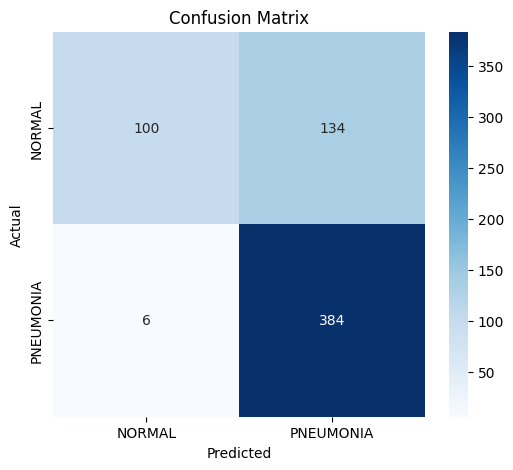

In [ ]:
# Evaluation on Test Set
test_images = []
test_labels = []
for imgs, lbls in test_ds:
    test_images.append(imgs.numpy())
    test_labels.append(lbls.numpy())

x_test = np.concatenate(test_images) # Combine the list of image arrays into a single numpy array
y_test = np.concatenate(test_labels) # Combine the list of label arrays into a single numpy array

y_pred_probs = model.predict(x_test) # Get the predicted class probabilities for the test set
y_pred = np.argmax(y_pred_probs, axis=1) # Get the predicted class index with the highest probability for each image

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names)) # Generate and print the classification report

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred) # Compute the confusion matrix
plt.figure(figsize=(6, 5)) # Create a figure for the confusion matrix plot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names) # Create a heatmap visualization of the confusion matrix
plt.xlabel("Predicted") # Set the x-axis label for the confusion matrix plot
plt.ylabel("Actual") # Set the y-axis label for the confusion matrix plot
plt.title("Confusion Matrix") # Set the title for the confusion matrix plot
plt.show() # Display the confusion matrix plot

Visualizing Model Decisions with Grad-CAM
To understand why the model makes certain predictions, we use Grad-CAM. This technique creates a heatmap highlighting the areas in an image that the model focuses on for a given class prediction.

Using 'conv5_block3_3_conv' as the last convolutional layer for Grad-CAM.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


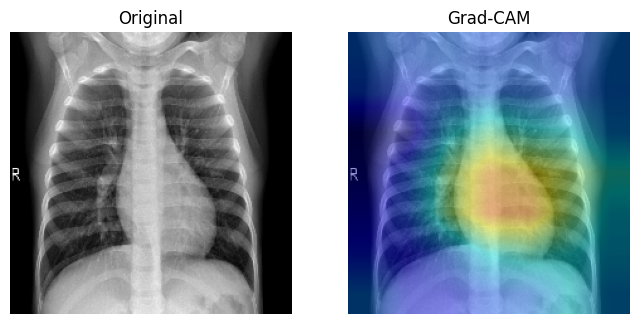

In [ ]:
import cv2
# Grad-CAM for Interpretability
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None): # Define a function to generate a Grad-CAM heatmap
    # Convert img_array to a TensorFlow tensor and ensure it's float32
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32) # Convert the input image array to a TensorFlow tensor for processing

    base_model_layer = model.get_layer('resnet50') # Get the base ResNet50 layer from the model

    feature_extractor = tf.keras.models.Model(
        inputs=base_model_layer.inputs,
        outputs=base_model_layer.get_layer(last_conv_layer_name).output
    ) # Create a model that outputs the feature maps from the last convolutional layer

    with tf.GradientTape() as tape: # Start a Gradient Tape to record operations for automatic differentiation
        tape.watch(img_tensor) # Start watching the image tensor to compute gradients with respect to it

        conv_outputs = feature_extractor(img_tensor) # Get the feature maps from the last convolutional layer

        x = conv_outputs
        for layer in model.layers[1:]:
            x = layer(x)
        predictions = x # Get the model's predictions for the input image

        if pred_index is None:
            pred_index = tf.argmax(predictions[0]) # If no prediction index is provided, use the index of the highest prediction probability
        class_channel = predictions[:, pred_index] # Get the output of the predicted class before the softmax activation

    grads = tape.gradient(class_channel, conv_outputs) # Compute the gradients of the predicted class output with respect to the last convolutional layer's feature maps
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)) # Compute the mean of the gradients over spatial dimensions (height, width)

    conv_outputs = conv_outputs[0] # Remove the batch dimension from the convolutional outputs

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis] # Compute the heatmap by weighting the feature maps with the pooled gradients
    heatmap = tf.squeeze(heatmap) # Remove single-dimensional entries from the shape of the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap) # Apply ReLU to the heatmap and normalize it to the range [0, 1]
    return heatmap.numpy() # Convert the heatmap tensor to a NumPy array

# Visualize Grad-CAM
def display_gradcam(image, heatmap, alpha=0.4): # Define a function to display the original image overlaid with the Grad-CAM heatmap

    img = np.uint8(255 * image) # Convert the image to an 8-bit unsigned integer representation (0-255) for OpenCV

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])) # Resize the heatmap to match the dimensions of the original image
    heatmap = 255 -np.uint8(255 * heatmap) # Invert the heatmap values and convert to 8-bit unsigned integers (for better visualization with certain colormaps)

    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) # Apply the JET colormap to the heatmap
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0) # Overlay the heatmap onto the original image with a specified transparency (alpha)
    return overlay # Return the overlaid image

# Apply to a few test images (modified to one image as per previous request)
# (Assuming base_model, x_test, model, class_names, y_test are defined earlier in your script)
last_conv_layer_name = None
for layer in base_model.layers[::-1]: # Iterate through the layers of the base model in reverse order
    if isinstance(layer, tf.keras.layers.Conv2D): # Check if the layer is a Conv2D layer
        last_conv_layer_name = layer.name # If it is, store its name as the last convolutional layer and break the loop
        break

if last_conv_layer_name is None: # If no Conv2D layer was found in the base model
    print("Could not find a Conv2D layer in the base_model. Grad-CAM might not work as expected.")
    last_conv_layer_name = 'conv5_block3_3_conv' # Fallback to a commonly used layer name in ResNet50
    print(f"Falling back to '{last_conv_layer_name}' for Grad-CAM.")

print(f"Using '{last_conv_layer_name}' as the last convolutional layer for Grad-CAM.")

# Process only the first image from x_test
img = x_test[150] # Select the 151st image from the test set (using index 150)
img_array_for_prediction = np.expand_dims(img, axis=0) # Add a batch dimension to the image array for prediction

predicted_class_index = np.argmax(model.predict(img_array_for_prediction)) # Get the index of the predicted class for the image
predicted_class_name = class_names[predicted_class_index] # Get the name of the predicted class

heatmap = make_gradcam_heatmap(img_array_for_prediction, model, last_conv_layer_name, pred_index=predicted_class_index) # Generate the Grad-CAM heatmap for the selected image and predicted class
overlay = display_gradcam(img, heatmap) # Create the overlaid image using the original image and the generated heatmap

plt.figure(figsize=(8, 4)) # Create a figure for displaying the original and Grad-CAM images
plt.subplot(1, 2, 1) # Create the first subplot for the original image
plt.imshow(img) # Display the original image
plt.title("Original") # Set the title for the original image plot
plt.axis("off") # Turn off the axis for the original image plot

plt.subplot(1, 2, 2) # Create the second subplot for the Grad-CAM overlaid image
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)) # Display the overlaid image (converting from BGR to RGB for matplotlib)
plt.title("Grad-CAM") # Set the title for the Grad-CAM plot
plt.axis("off") # Turn off the axis for the Grad-CAM plot
plt.show() # Display the plot